In [2]:
from pyaudi import gdual_double, gdual_vdouble
import pyaudi as pa 
import numpy as np
# import chaospy as cp 
import seaborn
# seaborn.set_style('whitegrid')
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
print(plt.style.available)
plt.style.use("seaborn-whitegrid")

from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
from Utils.submatrix import submatrix 

from scipy.integrate import odeint 
from scipy.integrate import cumtrapz

from Utils.SDRE import SDREC 
from Utils.ASRE import ASREC 
# from Utils.autograd_adjoint import odeint 

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


In [3]:
plt.style.use("seaborn-whitegrid")

# Goal 1
Compare forward sensitivity using DA+RK4 implementation with adjoint sensitivity, demostrating that they indeed produce the same information. 

In [8]:
# Problem Data 
def dynamics(x, t, a, u=lambda t,x,a: 0, math_module=pa):
    dx = np.zeros_like(x, dtype=type(a))
    dx[0] = x[1]
    dx[1] = -a*x[1]*math_module.sqrt(1e-5 + x[1]**2) + u(t,x,a)
    return dx 

def jacobian(x, a):
    return np.array([[0, 1, 0, 0],[0, -2*a*pa.sqrt(1e-5+x[1]**2), -x[1]*pa.sqrt(1e-5+x[1]**2), 1], [0,0,0,0], [0,0,0,0]])

tf = 3
t = np.linspace(0, tf, 300)

a = 0.25
x0 = [13, -5.5, a, 0] 

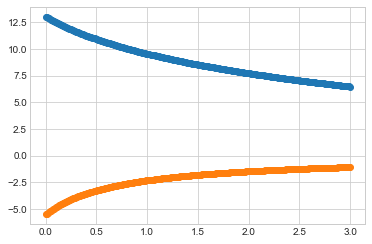

In [9]:
x = RK4(dynamics, x0[:2], t, args=(a, lambda t,x,a: 0))
xf = x[-1]
x_new = RK4(dynamics, xf, t[::-1], args=(a, lambda t,x,a: 0))

# Just verifying fwd/bkw integration 
plt.plot(t, x, 'o', label='Fwd')
# plt.plot(t, x_new[::-1], label='Bwd')
# plt.legend()
# plt.show()

Differential algebra solution

In [36]:
A = pa.gdual_double(a, 'a', 2)
X0 = da.make(x0, ['x1','x2', 'a', 'u'], 2)
du = pa.gdual_double(0, 'u', 2)

import time
q0 = time.time()
X = RK4(dynamics, X0, t, args=(A, lambda t,x,a: du))
print("DA Integration Time = {:.5} s".format(time.time()-q0))
names = ['x1','x2','a', 'u']
gradient = da.jacobian(X[-1], names)
stm = [da.jacobian(x, names) for x in X] # change in [x1, x2] wrt [x10, x20, a, u]
hessian = [da.hessian(x, names) for x in X[-1]]
print(stm[-1])
print(hessian[0])
print(hessian[1])

DA Integration Time = 0.32613 s
[[ 1.          0.58536596 13.26804771  2.08536646]
 [ 0.          0.03807263  3.45509133  1.23319522]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[[  0.           0.           0.           0.        ]
 [  0.           0.08566333  -1.88459235   0.08566336]
 [  0.          -1.88459235 -64.6832854   -1.88458903]
 [  0.           0.08566336  -1.88458903   0.48627344]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.11432095e-02 -2.45150211e-01  3.96976882e-02]
 [ 0.00000000e+00 -2.45150211e-01 -2.22473854e+01 -8.73343587e-01]
 [ 0.00000000e+00  3.96976882e-02 -8.73343587e-01  5.55284249e-01]]


Adjoint solution

[[ 1.          0.58535451 13.26828217  2.08535792]
 [ 0.          0.03807126  3.45510896  1.23319103]]


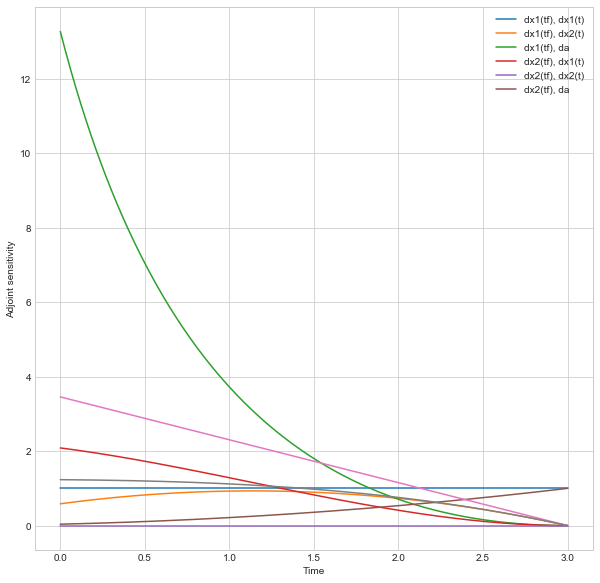

In [37]:
from scipy.interpolate import interp1d 

x = da.const(X, array=True)
x_interp = interp1d(t, x, axis=0, bounds_error=False, fill_value=(x[0],x[-1]))
# plt.plot(x.T[0],x.T[1])
def adjoint_dyn(p, t, X, J,):
    x = X(t)
    A = J(x)
    dp = -A.T.dot(p)
    return dp

J0 = []
P0 = np.eye(4)[:2]
plt.figure(figsize=(10,10))
for p0 in P0:
    Y = odeint(adjoint_dyn, p0, t[::-1], args=(x_interp, lambda x: jacobian(x,a),))
    plt.plot(t, Y[::-1])
    J0.append(Y[-1])
J0 = np.array(J0)
print(J0)

plt.xlabel('Time')
plt.ylabel('Adjoint sensitivity')
plt.legend(["dx1(tf), dx1(t)", "dx1(tf), dx2(t)", "dx1(tf), da","dx2(tf), dx1(t)", "dx2(tf), dx2(t)", "dx2(tf), da"])
plt.show()

In [38]:
assert np.allclose(gradient[:2], J0, rtol=1e-1, atol=1e-2), "Forward and Adjoint Sensitivities do not match!\nMax error = {:.3g}".format(np.max(np.abs(gradient[:2]-J0)))
print("Goal 1 achieved - adjoints recovered from forward sensitivities.")

Goal 1 achieved - adjoints recovered from forward sensitivities.


Subgoal: Determine the control costate with respect to the each state, i.e. $J = x_i$ for $i = {1,2}$

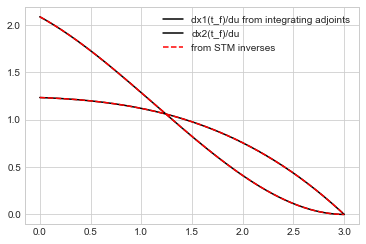

In [39]:
# This recovers the costates from STM 
dJdx = [[1, 0, 0, 0],[0,1,0,0]]
stmi = [np.linalg.inv(st) for st in stm]
stmf = stm[-1]
C = np.dot(dJdx, stmf)
p1 = np.array([np.dot(C, si) for si in stmi])

# p1 = [dx1/dx; dx2/dx]
dfdu = [0, 1, 0, 0]
# pu1 =  dx1(t_f)/du
pu1 = np.array( [np.trapz(x=t[i:], y=p1[i:,0,1]) for i in range(t.size)])  # Guaranteed to be correct
pu1_= -cumtrapz(x=t[::-1], y=np.squeeze(p1[::-1,0,1]), initial=0)[::-1] # so many weird flips required 
# Since integration is from tf to t, time and costate need to be reversed. Then, to plot against t, it must be reversed
# The negative sign is because pu1 is integrating forward, while pu1_ is integrating backward 
pu2 = np.array([np.trapz(x=t[i:], y=p1[i:,1,1]) for i in range(t.size)])

plt.figure()
plt.plot(t, pu1, 'k', label="dx1(t_f)/du from integrating adjoints")
# plt.plot(t, pu1_,'o')
plt.plot(t, pu2, 'k', label="dx2(t_f)/du")
plt.plot(t, p1[:, 0, 3], 'r--', label="from STM inverses")
plt.plot(t, p1[:, 1, 3], 'r--')

plt.legend()
plt.show()

In conclusion, we can obtain the backward sensitivities to changes in state, parameters, and control from the state transition matrices. 

# Goal 2: Entry equations
## Verify that the adjoints generated during Apollo can be gotten similarly using DA 

Possible different terminal points by storing STM or adjoint beyond the actual termination criteria? 

In [14]:
import sys
sys.path.append("./EntryGuidance")
from EntryEquations import Entry
from Simulation import Simulation, Cycle, EntrySim
from InitialState import InitialState
# from ParametrizedPlanner import profile
from scipy.interpolate import interp1d
from Apollo import gains 
        

In [15]:
x0 = InitialState()
Vf = 475 
ref_profile = lambda **args: 0.15
sim = Simulation(cycle=Cycle(0.1), output=True, **EntrySim(Vf=Vf))
res = sim.run(x0, [ref_profile])

Resetting simulation states.

L/D: 0.24
BC : 121.5942192075822 kg/m^2
current simulation time = 0 s
current simulation time = 10 s
current simulation time = 20 s
current simulation time = 30 s
current simulation time = 40 s
current simulation time = 50 s
current simulation time = 60 s
current simulation time = 70 s
current simulation time = 80 s
current simulation time = 90 s
current simulation time = 100 s
current simulation time = 110 s
current simulation time = 120 s
current simulation time = 130 s
current simulation time = 140 s
current simulation time = 150 s
current simulation time = 160 s
current simulation time = 170 s
current simulation time = 180 s
current simulation time = 190 s
current simulation time = 200 s
current simulation time = 210 s
current simulation time = 220 s
current simulation time = 230 s
current simulation time = 240 s
current simulation time = 250 s
current simulation time = 260 s
current simulation time = 270 s
current simulation time = 280 s
current simul

./EntryGuidance\Planet.py:123: RuntimeWarning: invalid value encountered in double_scalars
  PHI = sign(lonc-lon0)*arccos( (sin(latc) - sin(lat0)*cos(d13))/(cos(lat0)*sin(d13)) )


In [ ]:

# compute distance to SRP manifold along traj, assuming heading is aligned although it is not. It will be by the time the actual trigger occurs

# current velocity -> tf, T, mu -> downrange flown, altitude dropped -> actual remaining DR and altitude 

def manifold(sim):
    vx = V*np.cos(gamma)
    vy = V*np.sin(gamma)
    


In [6]:
dasim = Simulation(cycle=Cycle(0.2), output=True, use_da=True, **EntrySim(Vf=Vf), )
names = ['r', 'theta', 'phi', 'V', 'fpa', 'psi', 's', 'm']
x0d = da.make(x0, names, 1)
u = gdual_double(0.15, 'u', 1)
ref_profile = lambda **args: u

res = dasim.run(x0d, [ref_profile])

Resetting simulation states.

L/D: 0.24
BC : 121.594+0.0433646*dm kg/m^2
current simulation time = 0 s
current simulation time = 10 s
current simulation time = 20 s
current simulation time = 30 s
current simulation time = 40 s
current simulation time = 50 s
current simulation time = 60 s
current simulation time = 70 s
current simulation time = 80 s
current simulation time = 90 s
current simulation time = 100 s
current simulation time = 110 s
current simulation time = 120 s
current simulation time = 130 s
current simulation time = 140 s
current simulation time = 150 s
current simulation time = 160 s
current simulation time = 170 s
current simulation time = 180 s
current simulation time = 190 s
current simulation time = 200 s
current simulation time = 210 s
current simulation time = 220 s
current simulation time = 230 s
current simulation time = 240 s
current simulation time = 250 s
current simulation time = 260 s
current simulation time = 270 s
current simulation time = 280 s
current si

In [12]:
if 0: # get Lx and integrate to get Lu
    # get stms for longitudinal states 
    long = [6, 3, 4, 0]
    stm = [submatrix(da.jacobian(x, names), long) for x in dasim.history]
    # stm = [da.jacobian(x, names+['u']) for x in dasim.history]

    print(stm[-1].shape)

    # get adjoints 

    dJdx = [1, 0, 0, -1.0/np.tan(dasim.history[-1, 4].constant_cf)]

    stmi = [np.linalg.inv(st) for st in stm]
    stmf = stm[-1]
    C = np.dot(dJdx, stmf)
    Lx = np.array([np.dot(C, si) for si in stmi])

    dfdu = [0, 0, 1, 0]
    t = dasim.times
    # pu1 =  dx1(t_f)/du
    df = dasim.df
    integrand = da.const((df['drag']/df['velocity']).values, array=True) * Lx[:, 2]
    Lu =np.array( [np.trapz(x=t[i:], y=integrand[i:]) for i in range(len(t))])
    L = np.c_[Lx, Lu[:, None]]
    
else:  # Get all of them together 
    
    # get stms for longitudinal states 
    rows = [6, 3, 4, 0]
    cols = rows + [-1] # get the derivs wrt controls too 
    stm = [np.vstack([submatrix(da.jacobian(x, names+['u']), rows, cols), np.eye(5)[-1]]) for x in dasim.history]

    print(stm[-1])

    # get adjoints 

    dJdx = [1, 0, 0, -1.0/np.tan(dasim.history[-1, 4].constant_cf), 0]

    stmi = [np.linalg.inv(st) for st in stm]
    stmf = stm[-1]
    C = np.dot(dJdx, stmf)
    L = np.array([np.dot(C, si) for si in stmi])
    L[:,-1] *= -1/0.24/np.sin(0.15)  # This converts from sensitivity in sigma to sensitivity of u = L/D cos(sigma)

[[ 1.00000000e+00  3.61963362e+02  1.17187363e+07  1.17438048e+01
  -1.23853506e+05]
 [ 0.00000000e+00  7.14595728e-01  2.39482649e+04  2.08565297e-02
  -3.90411128e+02]
 [ 0.00000000e+00  4.58569137e-04  1.46534973e+01  1.22314224e-05
  -2.61582342e-01]
 [ 0.00000000e+00  1.77520652e+01  6.06976820e+05  5.27592058e-01
  -1.01594834e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]]


In [ ]:
# The product of lambda.T.dot(STM) should be constant for all t 

In [8]:
V = da.const(dasim.history[:, 3])
imax = np.argmax(V)

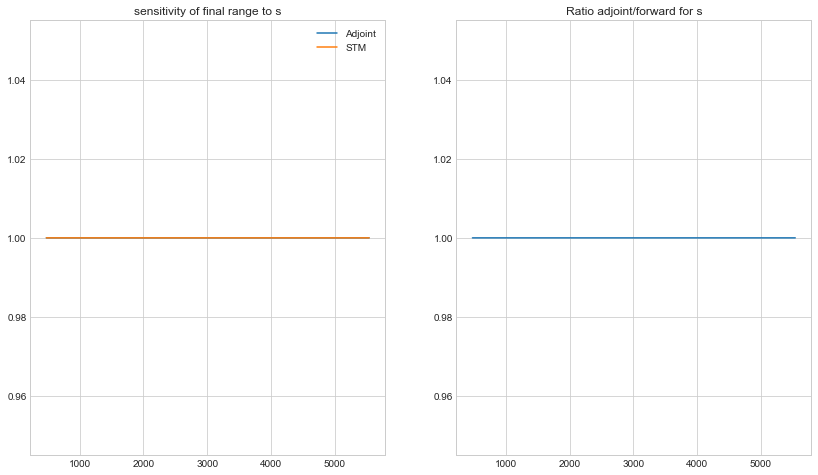

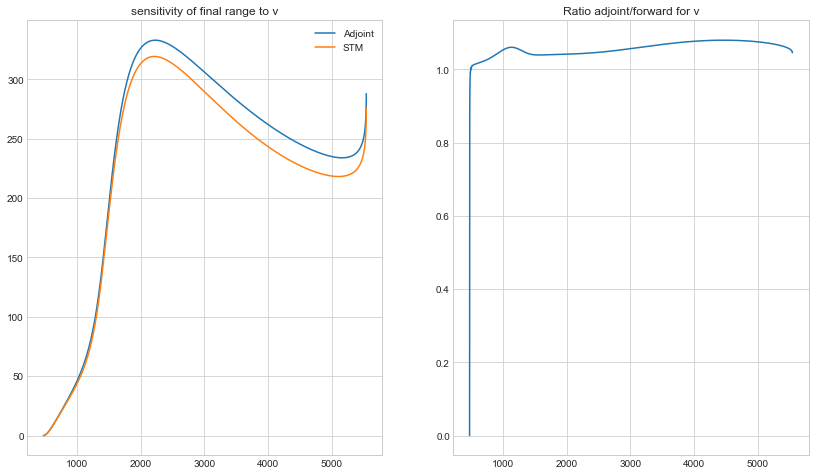

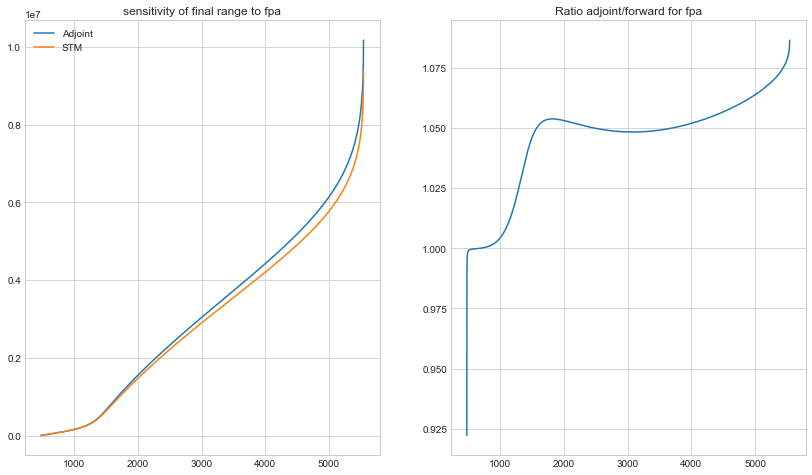

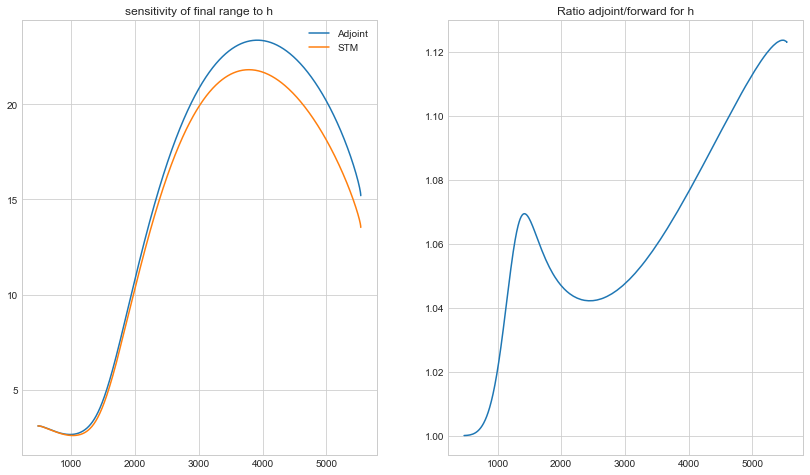

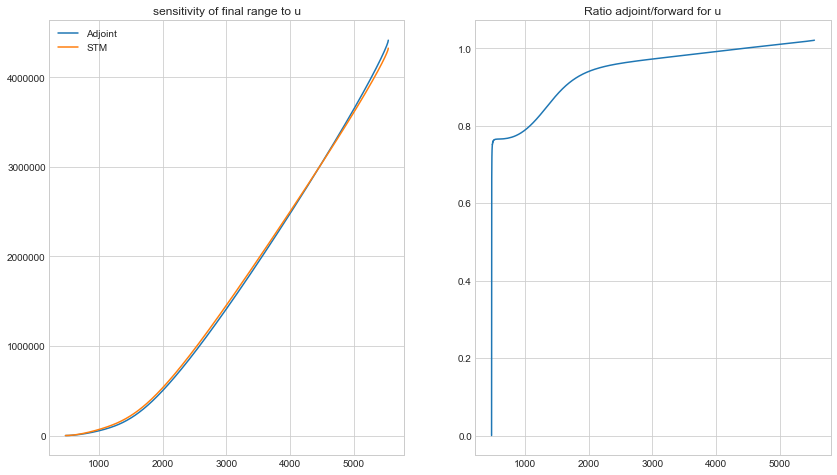

In [13]:
apollo = gains(sim)
nams = ['s','v','fpa', 'h', 'u']
for adj, name, adj_stm in zip(apollo['L'].T, nams, L.T):
    plt.figure(figsize=(14, 8))
    plt.subplot(1,2,1)
    plt.plot(apollo['IV'], adj, label='Adjoint')
    plt.plot(V[imax:], adj_stm[imax:], label='STM')

    plt.title("sensitivity of final range to {}".format(name))
    plt.legend()
    
    plt.subplot(1, 2, 2)
    r = adj / interp1d(V[imax:], adj_stm[imax:])(apollo['IV'])
    plt.plot(apollo['IV'][1:], r[1:])
    plt.title("Ratio adjoint/forward for {}".format(name))

# Terminal Point Control

Any (first order) "terminal point" controller$^1$, takes the form 
\begin{align}
\Delta u =  \frac{\Delta J}{\lambda_u} =\frac{\lambda_x^T\Delta x}{\lambda_u} 
\end{align}
where $\lambda_q(t) \triangleq \frac{\partial J(x(t_f))}{\partial x(t_f)}\frac{\partial x(t_f)}{\partial q(t)} $. This can also be written in terms of the first order state transtion matrix 
\begin{align}
\lambda_x(t) = \frac{\partial J(x_f)}{\partial x_f}\Phi(t_f)\Phi^{-1}(t) \\
\Delta u =  \frac{\Delta x^T\left( \frac{\partial J}{\partial x}\Phi(t_f)\Phi^{-1}(t)\right)}{\lambda_u} 
\end{align}

Note the following general relationship between adjoint and forward sensitvity
\begin{align}
\lambda_x(t) &= \Phi(t_f)\Phi^{-1}(t) \\
\Phi(t) &= \lambda^{-1}(t)\lambda(t_0)
\end{align}

1. i.e., one that seeks to drive the variation in the Mayer objective to zero despite small variations in state/parameters from the nominal

In [88]:
# Use any reference traj, select a nearby initial condition, and use the TPC to drive it to the same terminal condition at tf. 
from scipy.interpolate import interp1d 

class TPC:
    """ A terminal manifold controller 
    
        Relatively general, can be further generalized where a is all parameters
    
    """
    def __init__(self, t, x, u, a, px, pu):
        self.t = t
        self.x = interp1d(t, x, axis=0, bounds_error=False, fill_value=(x[0],x[-1]))
        self.u = interp1d(t, u, axis=0, bounds_error=False, fill_value=(u[0],u[-1]))
        self.pu = interp1d(t, pu, axis=0, bounds_error=False, fill_value=(pu[0],pu[-1]))
        self.px = interp1d(t, px, axis=0, bounds_error=False, fill_value=(px[0],px[-1]))
        self.a = a

        
    def __call__(self, t, x, a):
        
        px = self.px(t)
        pu = self.pu(t)
        if np.abs(pu) < 1e-2:
            pu = np.sign(pu)*1e-2
        if pu == 0:
            pu = 1.0e6
            
        if np.ndim(x) == 1 and np.ndim(a) == 0:  # Scalar scenario
            dx = np.append(x-self.x(t), a-self.a)
#             dx = np.append(x-self.x(t), 0) # This is the case where we don't know/measure a 

            return self.u(t) - np.dot(dx, px)/pu
        
        else:
            if np.ndim(x) > 1:
                dx = x-self.x(t)[:,None]
            else:
                dx = x-self.x(t)
                
            da = a - self.a  # doesn't matter if a is an array or scalar 
            return self.u(t) - (px[-1]*da + np.dot(px[:-1], dx))/pu

        
class TPC2:
    """ A terminal manifold controller using a different indepdendent variable 
        
        Can only be used when the velocity term is monotonic 
        
    
    """
    def __init__(self, t, x, u, a, px, pu):
        v = x.T[1]  # negative and monotonically increasing 
        start = 0
        final = -1
        
        self.t = t
        self.x = interp1d(v, x, axis=0, bounds_error=False, fill_value=(x[start],x[final]))
        self.u = interp1d(v, u, axis=0, bounds_error=False, fill_value=(u[start],u[final]))
        self.pu = interp1d(v, pu, axis=0, bounds_error=False, fill_value=(pu[start],pu[final]))
        self.px = interp1d(v, px, axis=0, bounds_error=False, fill_value=(px[start],px[final]))
        self.a = a
        
    def __call__(self, t, x, a):
        v = x[1]
        px = self.px(v).T
        pu = self.pu(v)
        
        if np.ndim(pu) > 0:
            pu[pu==0] = 1.0e6
            pu[np.abs(pu)<=1e-2] = 1e-2*np.sign(pu[np.abs(pu)<=1e-2])
        else:
            if np.abs(pu) < 1e-2:
                pu = np.sign(pu)*1e-2
            if pu == 0:
                pu = 1.0e6
            
        if np.ndim(x) == 1 and np.ndim(a) == 0:  # Scalar scenario
            dx = np.append(x-self.x(v), a-self.a)
            return self.u(v) - np.dot(dx, px)/pu
        
        else:
            if np.ndim(x) > 1:
                dx = x-self.x(v).T
            else:
                dx = x-self.x(v)
                
            da = a - self.a  # doesn't matter if a is an array or scalar 
            return self.u(v) - (px[-1]*da + px[0]*dx[0])/pu

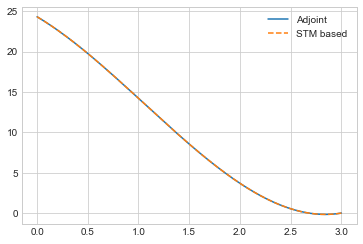

In [89]:
def Obj(xf):
    return xf[0]**2 + xf[1]**2  # match the manifold
#     return xf[0]  # match position
#     return xf[1]  # match velocity 
#     return xf[0]*xf[1]
#     return xf[0] + xf[1]
#     f = xf[0] 
#     g = xf[1]

#     if np.ndim(xf)>1:
#         return np.cos(f) + g**2
#     else:
#         return pa.cos(f) + g**2

Xf = da.make([x[-1,0],x[-1,1], a, 0], names, 2)
dJdx = da.gradient(Obj(Xf), names)
Jxx = da.hessian(Obj(Xf), names)
C = np.dot(dJdx, stmf)
px = np.array([np.dot(C, si) for si in stmi])
pu1 = np.array( [np.trapz(x=t[i:], y=px[i:, 1]) for i in range(t.size)])
pu = px[:,3]
plt.plot(t, pu1, label='Adjoint')
plt.plot(t, pu, '--', label='STM based')
plt.legend()
controller = TPC(t, x[:,:2], np.zeros_like(t), a, px[:,:3], pu)  # The costates passed here determine the objective 
sat_controller = lambda t,x,a: np.clip(controller(t,x,a), -10, 10)

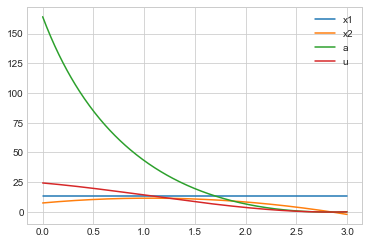

In [90]:
plt.plot(t, px)
plt.legend(['x1','x2', 'a','u'])
plt.show()

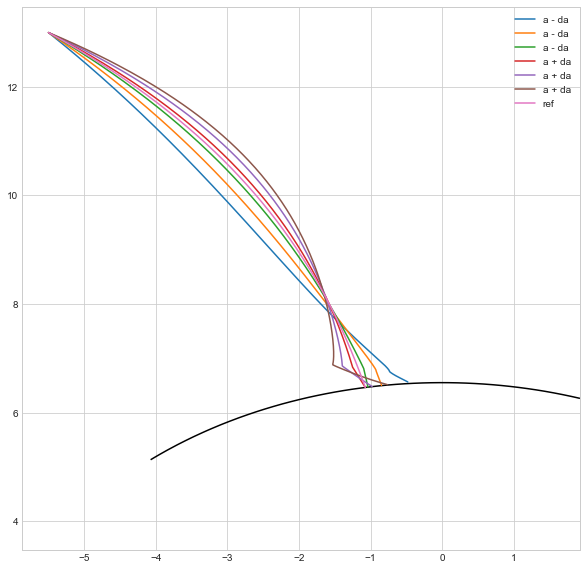

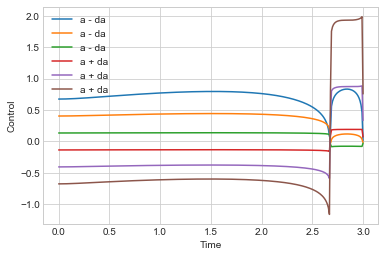

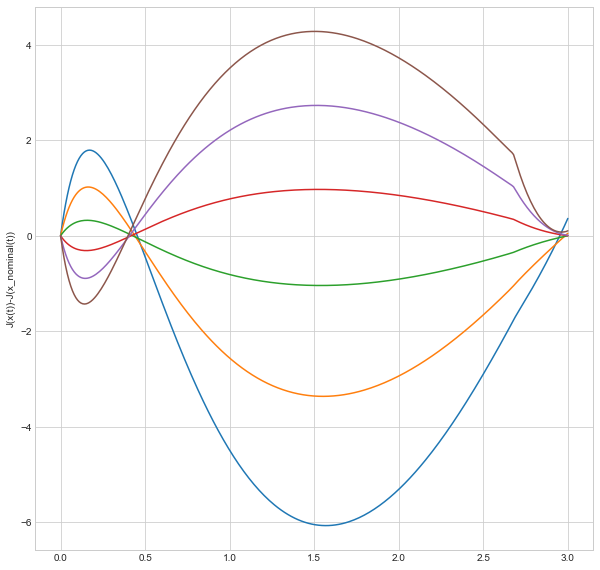

In [91]:
# Lets try just initial condition uncertainty, and just parametric uncertainty 

# Parametric Uncertainty 
X,Y = np.meshgrid(x[-1,0] + np.linspace(-1,1)*3,x[-1,1] + np.linspace(-1,1)*3)
plt.figure(1,figsize=fs)
plt.contour(Y, X, Obj([X,Y]), [Obj(x[-1])], colors='k',alpha=1)

fs = (10,10)
J0 = Obj(x.T)
# plt.figure(3, figsize=fs)
# plt.plot(t, Obj(x.T), 'k')

for delta_a in np.linspace(-0.1, 0.1, 6): #[-0.035,  0.035]:
    label = "+"
    if delta_a < 0:
        label = "-"
    xnew = odeint(dynamics, x0[:2], t, args=(a+delta_a, sat_controller))
    unew = [sat_controller(ti, xi, a+delta_a) for ti,xi in zip(t,xnew)]

    plt.figure(1, figsize=fs)
    plt.plot(xnew.T[1], xnew.T[0], label='a {} da'.format(label))

    plt.figure(2)
    plt.plot(t, unew, label='a {} da'.format(label))
    plt.xlabel('Time')
    plt.ylabel('Control')
    plt.legend()
    
    plt.figure(3, figsize=fs)
    plt.plot(t, Obj(xnew.T)-J0)
    plt.ylabel("J(x(t))-J(x_nominal(t))")

plt.figure(1)
plt.plot(x.T[1], x.T[0], label='ref')
plt.legend()
plt.show()

Even for this toy problem with mild drag-like nonlinearity, the linearization results in poor performance unless additional gain is introduced. Of course, performance can also be enhanced by using a different monotonic independent variable, but this is problem dependent and not always possible. Another way we can improve performance in differentiable systems is to include second order sensitivities. 

(300, 2, 500)


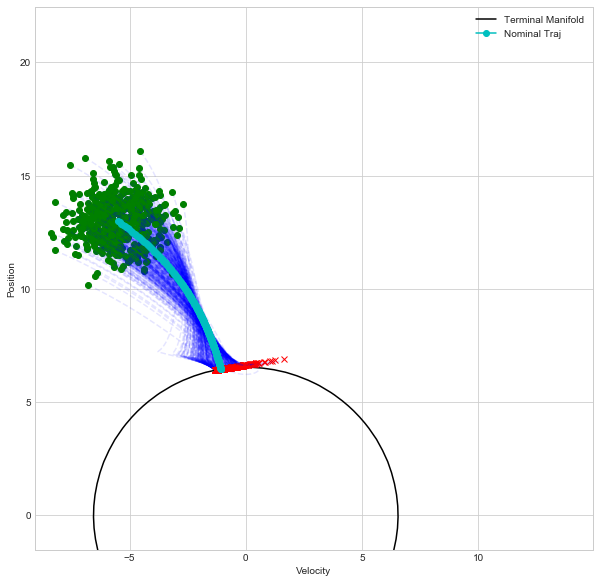

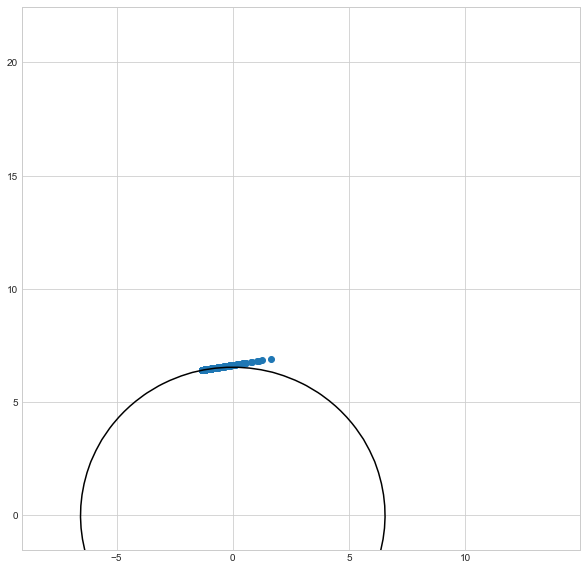

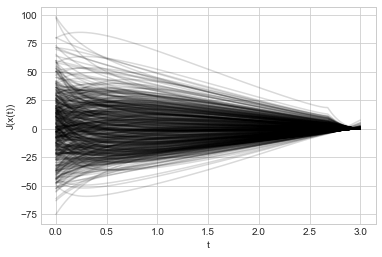

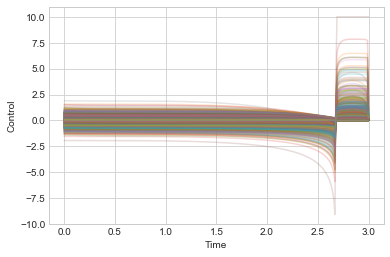

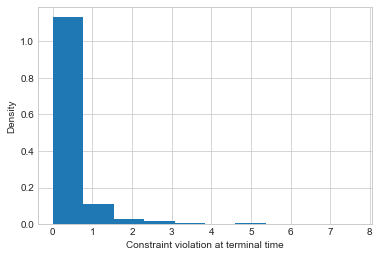

In [93]:

plt.figure(1, figsize=(10,10))
X,Y = np.meshgrid(x[-1,0] + np.linspace(-1,2)*8,x[-1,1] + np.linspace(-1,2)*8)
plt.contour(Y, X, Obj([X,Y]), [Obj(x[-1])], colors='k',alpha=1)
plt.plot(0, 0, 'k', label="Terminal Manifold") # Just for the label

plt.figure(4, figsize=(10,10))
X,Y = np.meshgrid(x[-1,0] + np.linspace(-1,2)*8,x[-1,1] + np.linspace(-1,2)*8)
plt.contour(Y, X, Obj([X,Y]), [Obj(x[-1])], colors='k',alpha=1)
plt.plot(0, 0, 'k', label="Terminal Manifold") # Just for the label

x0_mc = np.random.multivariate_normal(x0[:2], np.diag([1,1]), 500).T
x_mc = RK4(dynamics, x0_mc, t, args=(a, sat_controller, np))
print(x_mc.shape)
plt.scatter(x_mc[-1,1], x_mc[-1,0])

C = []
for xnew in np.transpose(x_mc, (2,0,1)):
    C.append(Obj(xnew.T)[-1]-J0[-1])
    plt.figure(1)
    plt.plot(xnew.T[1], xnew.T[0], 'b--', alpha=0.1)
    plt.plot(xnew[0,1], xnew[0,0], 'go') # IC
    plt.plot(xnew[-1,1], xnew[-1,0], 'rx')  # FC


    plt.figure(3)
    plt.plot(t, Obj(xnew.T)-J0, 'k', alpha=0.15)
    plt.ylabel("J(x(t))")
    plt.xlabel('t')
    
    unew = [sat_controller(ti, xi, a) for ti,xi in zip(t,xnew)]
    plt.figure(2)
    plt.plot(t, unew, alpha=0.2)
    plt.xlabel('Time')
    plt.ylabel('Control')
    
plt.figure(1)
plt.plot(x.T[1], x.T[0], 'c-o', label='Nominal Traj')
plt.ylabel("Position")
plt.xlabel("Velocity")
plt.legend()

plt.figure(5)
plt.hist(C, density=True)
plt.xlabel("Constraint violation at terminal time")
plt.ylabel("Density")

plt.show()

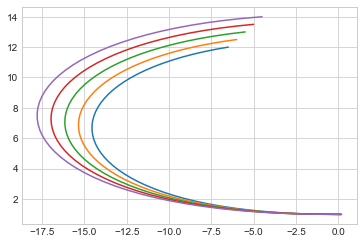

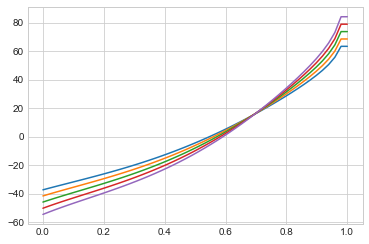

In [48]:
# Quick comparison with constrained SDRE?
def dynamics_riccati(x, t, a, u=lambda t,x,a: 0, math_module=pa):
    dx = np.zeros_like(x, dtype=type(a))
    dx[0] = x[1]
    U = u(t,x,a)[1][0][0]
    dx[1] = -a*x[1]*math_module.sqrt(1e-5+x[1]**2) + U
    return dx 

def A(t, x):
    return np.array([[0,1],[0, -a*np.sqrt(1e-5+x[1]**2)]])

def B(t,x,u):
    return np.array([[0],[1]])

def C(t, x):
    return np.eye(2)

def Q(t,x):
    return np.eye(2)*0

def R(t,x,u):
    return [[1]]

Sf = np.eye(2)*0
# z = x[-1, :2]  # Match reference end point
# z = np.zeros((2))
z = [1,-0.1]
m = 1

# asre_controller = lambda t,x,a: ASREC(x, np.linspace(min(t,tf-1e-3), tf, 10), A, B, np.eye(2), Q, R, Sf, z, m, max_iter=2, tol=0.01, verbose=False)
# x_asre = RK4(dynamics_riccati, x0[:2], t, args=(a, asre_controller, np))

# sdre_controller = lambda t,x,a: SDREC(x, tf, A, B, C, Q, R, Sf, z, m, n_points=20, minU=None, maxU=None, verbose=False)
# x_sdre = RK4(dynamics_riccati, x0[:2], t, args=(a, sdre_controller, np))
npoints=50
tfn = 1
# N = int(npoints*tfn)
N = 50
for delta in [-1, -0.5, 0, 0.5, 1]:
    xn = np.array(x0[:2]) + delta
    x_sdre, u_sdre, _ = SDREC(xn, tfn, A, B, C, Q, R, Sf, z, m, n_points=N, minU=None, maxU=None, verbose=False)
    plt.figure(1)
    plt.plot(x_sdre.T[1], x_sdre.T[0], label='SDRE')

    plt.figure(2)
    plt.plot(np.linspace(0, tfn, N), u_sdre)
    
# plt.figure(1)
# plt.plot(x.T[1], x.T[0], 'k--', label='ref')
# plt.legend()
plt.show()


# Higher Order Neighboring Solutions

- Use map inversion techniques to generate higher order analogues of the adjoint sensitivity
- Solve for the control update as a polynomial root or as a linear function

In [13]:
names = ['X1','X2','A', 'U']
pvars = np.array(["p{}".format(i) for i in range(len(names))])
Isort = np.argsort(["p2", "p3", "p0", "p1"])
# pvars = pvars[Isort]
pzero = 0*np.sum(da.make(np.zeros((4,)), pvars, 2, True))

X0 = da.make(x0, names, 2)
X0 += np.zeros_like(X0)*np.sum(X0)  # This guarantees each DA has all the variables, a requirement for map inversion later 
X = RK4(dynamics, X0, t, args=(X0[2], lambda t,x,a: X0[3]))

x = da.const(X, array=True)

J = Obj(X[-1])
dJ = da.differentiate(J, names)

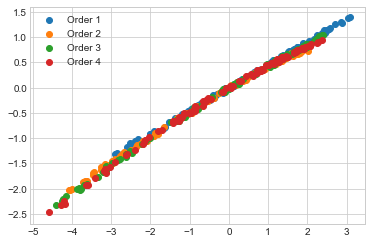

In [14]:
# Confirm that higher order expansions have effect on control?

for order in [1,2,3,4]:
    X0 = da.make(x0, names, order)
    X = RK4(dynamics, X0, t, args=(X0[2], lambda t,x,a: X0[3]))
    Xf = X[-1]
    if 0:
        du  = np.linspace(-1,1,100)*0.2
        d = np.zeros((100, 3))
        dx = np.concatenate((d, du[:,None]), axis=1)
    else:
        dx = -0.05 + np.random.random((100,4))*0.1
    
    xf = da.evaluate(Xf, names, dx)
    plt.scatter(xf.T[0] - da.const(Xf[0]), xf.T[1]- da.const(Xf[1]), label='Order {}'.format(order))
plt.legend()
plt.show()

Timing comparison, compare map inversion times for 1/2/3 order expansions with the matrix inversions required for first order 

In [374]:
# 
import time 

t0 = time.time()
stm = [da.jacobian(x, names) for x in X]
stmi = [np.linalg.inv(st) for st in stm]
t_stm = time.time()
print("STM differentiation and matrix inversion: {:.2f} s".format(t_stm-t0))

for order in [1,2,3]:
    X0 = da.make(x0, names, order)
    X0 += np.zeros_like(X0)*np.sum(X0)  # This guarantees each DA has all the variables, a requirement for map inversion later 
    X = RK4(dynamics, X0, t, args=(X0[2], lambda t,x,a: X0[3]))

    x = da.const(X, array=True)
    dX = X-x
    
    t0 = time.time()
    Mi = np.array([pa.invert_map(M) for M in dX])
    tf = time.time()

    if False:
        print(M[0].symbol_set)
        print(Mi[0][0].symbol_set)

        # The use of Isort here is because of the above ordering of inverse variables (p)
        # which corresponds to the sorted DA vars 
        print(stmi[-1])
        print(da.jacobian(Mi[-1], pvars)[Isort])

#     print(Mi[-1])
    print("Map inversion, order={}: {:.2f} s".format(order, tf-t0))


STM differentiation and matrix inversion: 0.01 s
Map inversion, order=1: 0.05 s
Map inversion, order=2: 0.21 s
Map inversion, order=3: 0.92 s


Algorithm for higher order control:
- Store polynomials: initial to constraint, and current to initial 
- Store reference states 
- Compute current differences from reference
- Map delta backward then forward
- Compute control that nulls change in terminal constraint

In [358]:
class HOTPC:
    """ A high order terminal manifold controller 
    
        Relatively general, can be further generalized where a is all parameters
    
    """
    def __init__(self, t, x, u, a, constraint, inverse_maps, pu, names):
        self.t = t
        self.x = interp1d(t, x, axis=0, bounds_error=False, fill_value=(x[0],x[-1]))
        self.u = interp1d(t, u, axis=0, bounds_error=False, fill_value=(u[0],u[-1]))
        self.pu = interp1d(t, pu, axis=0, bounds_error=False, fill_value=(pu[0],pu[-1]))

        self.Mf = [constraint]
        self.Mi = inverse_maps
        self.a = a
        self.vars = names 
        self.pvars = np.array(["p{}".format(i) for i in range(4)])
        
    def __call__(self, t, x, a):
        
        i,w0,w1 = self.get_data(t)
        Mi  = self.Mi[i]*w0 + self.Mi[i+1]*w1 # Inverse map 
        
        pu = self.pu(t)
        if np.abs(pu) < 1e-3:
            pu = np.sign(pu)*1e-2
        if pu == 0:
            pu = 1.0e6
            
        if np.ndim(x) == 1 and np.ndim(a) == 0:  # Scalar scenario
            dx = np.append(x-self.x(t), [a-self.a, 0])
            dx0 = da.evaluate(Mi, self.pvars, [dx])
            dJ = da.evaluate(self.Mf, self.vars, dx0)[0]  # The change in constraint to be corrected by the controller 

            return self.u(t) - dJ/pu
        
        else: # Only scalar scenarios for now...
            pass

        
    def get_data(self, t):
        
        i = np.searchsorted(self.t, t)
        i = min(self.t.size-2, i)
        tlow = self.t[i]
        thigh = self.t[i+1]
        dt = thigh-tlow
        w0 = (t-tlow)/dt
        w1 = (thigh-t)/dt

        return i, w0, w1   

In [405]:
tf = 3
t = np.linspace(0, tf, 300)

a = 0.05
x0 = [13, -5.5, a, 0] 
names = ['X1','X2','A', 'U']

order = 6
X0 = da.make(x0, names, order)
X0 += np.zeros_like(X0)*np.sum(X0)  # This guarantees each DA has all the variables, a requirement for map inversion later 
X = RK4(dynamics, X0, t, args=(X0[2], lambda t,x,a: X0[3]))

x = da.const(X, array=True)
dX = X-x
# plt.figure()
# plt.plot(x.T[1],x.T[0])

pvars = np.array(["p{}".format(i) for i in range(len(names))])
Isort = np.argsort(["p2", "p3", "p0", "p1"])
unsort = np.argsort(names)
Mi = np.array([pa.invert_map(M) for M in dX])[:, Isort]  # The inverse maps 

def Obj(xf):
    return xf[0]**2 + xf[1]**2  # match the manifold
#     return xf[0]  # match position
#     return xf[1]  # match velocity 
#     return xf[0]*xf[1]
#     return xf[0] + xf[1]

J = Obj(X[-1])  # Map of constraint value as function of initial states/params 
dJ = J - da.const(J)

Xf = da.make([x[-1,0],x[-1,1], a, 0], names, 1)
dJdx = da.gradient(Obj(Xf), names)
stm = [da.jacobian(x, names) for x in X]
stmi = [np.linalg.inv(st) for st in stm]
p = np.array([dJdx.dot(stm[-1]).dot(st) for st in stmi])  # adjoints
pu = p[:, 3] 
# plt.figure()
# plt.plot(t, pu, '--', label='STM based')
# plt.legend()
controller = HOTPC(t, x[:,:2], np.zeros_like(t), a, dJ, Mi, pu, names)
sat_controller = lambda t,x,a: np.clip(controller(t,x,a), -10, 10)


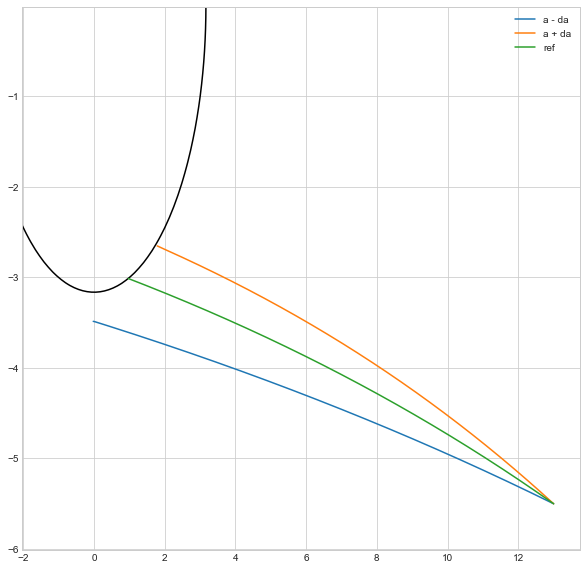

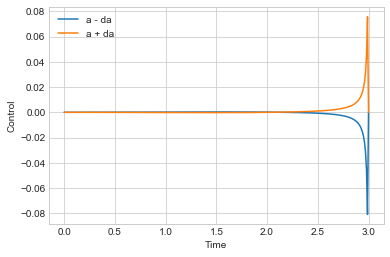

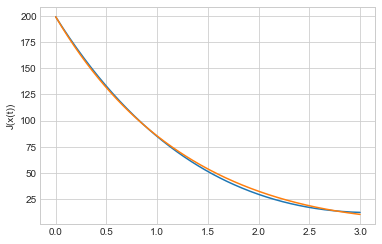

In [406]:
# Parametric Uncertainty 

plt.figure(1, figsize=(10,10))

X,Y = np.meshgrid(x[-1,0] + np.linspace(-1,1)*3,x[-1,1] + np.linspace(-1,1)*3)
plt.contour(X, Y, Obj([X,Y]), [Obj(x[-1])], colors='k',alpha=1)

for delta_a, label in zip([-0.015,  0.015], ["-","+"]):
    xnew = odeint(dynamics, x0[:2], t, args=(a+delta_a, sat_controller))
    unew = [sat_controller(ti, xi, a+delta_a) for ti,xi in zip(t,xnew)]

    plt.figure(1)
    plt.plot(xnew.T[0], xnew.T[1], label='a {} da'.format(label))

    plt.figure(2)
    plt.plot(t, unew, label='a {} da'.format(label))
    plt.xlabel('Time')
    plt.ylabel('Control')
    plt.legend()
    
    plt.figure(3)
    plt.plot(t, Obj(xnew.T))
    plt.ylabel("J(x(t))")
    
plt.figure(1)
plt.plot(x.T[0], x.T[1], label='ref')
plt.legend()
plt.show()

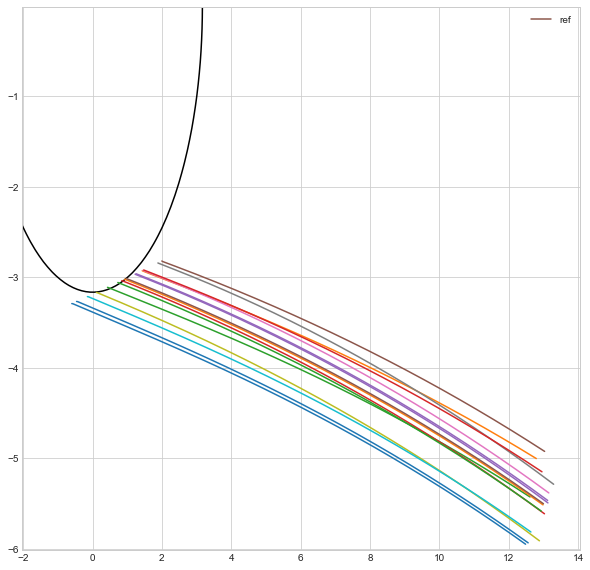

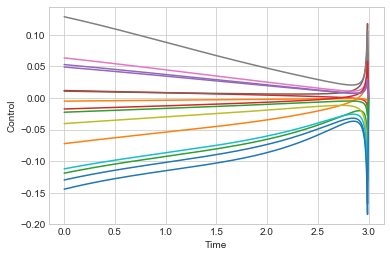

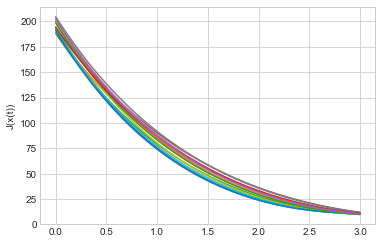

In [407]:
plt.figure(1, figsize=(10,10))

X,Y = np.meshgrid(x[-1,0] + np.linspace(-1,1)*3,x[-1,1] + np.linspace(-1,1)*3)
plt.contour(X, Y, Obj([X,Y]), [Obj(x[-1])], colors='k',alpha=1)

x0_mc = np.random.multivariate_normal(x0[:2], np.diag([1,1])*0.1, 15)

for x0_new in x0_mc:
    xnew = odeint(dynamics, x0_new, t, args=(a, sat_controller))
    unew = [sat_controller(ti, xi, a) for ti,xi in zip(t,xnew)]

    plt.figure(1)
    plt.plot(xnew.T[0], xnew.T[1])

    plt.figure(2)
    plt.plot(t, unew)
    plt.xlabel('Time')
    plt.ylabel('Control')
    
    plt.figure(3)
    plt.plot(t, Obj(xnew.T))
    plt.ylabel("J(x(t))")
    
plt.figure(1)
plt.plot(x.T[0], x.T[1], label='ref')
plt.legend()
plt.show()

In [318]:
dx0 = [[0.1, 0.5, 0.005, 0.3]]
i = -1
dxf = da.evaluate(dX[i], names, dx0)
dx0_check = da.evaluate(Mi[i], pvars, [(dxf).tolist()])
try:
    assert (np.allclose(dx0[0], dx0_check))
except AssertionError:
    print("Inverse operations did not commute exactly ")
    print(dx0_check)

#     print()
# Mf

Inverse operations did not commute
[0.10192239 0.49935627 0.005      0.3       ]


In [289]:
print(dX[0])
print(Mi[0][Isort])

print(dX[-1])
print(Mi[-1][Isort])

[dX1 dX2 dA dU]
[dp0 dp1 dp2 dp3]
[-49.5*dA*dU-49.5*dA*dX2+136.125*dA+dX1-1497.38*dA**2+4.5*dU+3*dX2
 -49.5*dA*dU-33*dA*dX2+90.75*dA-1497.38*dA**2+3*dU+dX2 dA dU]
[dp0+136.125*dp2-3.22974e-016*dp3**2+3.22974e-016*dp1*dp3+1497.38*dp2**2-3*dp1+49.5*dp2*dp3-49.5*dp1*dp2+4.5*dp3
 3.22974e-016*dp3**2-2.15316e-016*dp1*dp3-3*dp3-49.5*dp2*dp3+33*dp1*dp2-1497.38*dp2**2-90.75*dp2+dp1
 dp2-6.52473e-018*dp3 dp3]


# Goal: Independent Variable Sensitivity

How do the problem sensitivities change when using a different IV?

In [ ]:
def dynamics(x, t, a, u=lambda t,x,a: 0, math_module=pa):
    dx = np.zeros_like(x, dtype=type(a))
    dx[0] = x[1]
    dx[1] = -a*x[1]*math_module.sqrt(1e-5+x[1]**2) + u(t,x,a)
    return dx 

def jacobian(x, a):
    return np.array([[0, 1, 0, 0],[0, -2*a*pa.sqrt(1e-5+x[1]**2), -x[1]*pa.sqrt(1e-5+x[1]**2), 1], [0,0,0,0], [0,0,0,0]])

tf = 3
t = np.linspace(0, tf, 300)

a = 0.05
x0 = [13, -5.5, a, 0] 